# Data Preporcessing

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import math
import pickle
from sklearn.metrics import roc_auc_score
import optuna
import catboost as cb
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')
from tqdm.auto import tqdm

In [2]:
!wget -O "train.csv" -q "https://www.dropbox.com/s/5bz5a968eeryroj/churn_prediction.csv?dl=0"
data = pd.read_csv('train.csv')
data.sample(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
4923,72,104.45,7459,Male,0,Yes,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),0
2662,15,50.75,688.2,Male,0,No,No,No,No phone service,DSL,No,No,Yes,No,Yes,Yes,One year,No,Electronic check,0
4133,2,19.85,52,Female,0,Yes,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Bank transfer (automatic),0
5261,72,99.90,7251.7,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,No,Yes,Yes,No,Two year,No,Bank transfer (automatic),0
5232,27,66.15,1874.45,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,Yes,No,No,One year,No,Mailed check,0


In [3]:
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors ='coerce')
data.TotalSpent.fillna(data.TotalSpent.mean(), inplace=True)

In [4]:
y = data['Churn']
X = data.drop(columns='Churn')

In [5]:
categ_data = X.select_dtypes([np.object0])
cat_features = categ_data.columns.tolist()

# Training

In [6]:
class Boosting:

    def __init__(self, X_train, X_val, y_train, y_val, cat_features, params = None):
        print("Init...")
        self.X_train = X_train
        self.X_val = X_val
        self.y_train = y_train
        self.y_val = y_val
        self.cat_features = cat_features
        self.params = params
        self.model = None
        self.best_params = None
        self.top_features = None
        self.train_pool = cb.Pool(data = X_train, label = y_train, cat_features = cat_features)
        self.val_pool = cb.Pool(data = X_val, label = y_val, cat_features = cat_features)
        print("Init Finished!")

    def train(self):
        if self.params is None:
            model = cb.CatBoostClassifier(
                learning_rate = 0.303,
                depth = 3,
                l2_leaf_reg = 2.437,
                random_seed = 42,
                min_data_in_leaf = 30,
                one_hot_max_size = 40,
                colsample_bylevel = 0.079,
                loss_function = 'Logloss',
                task_type = 'CPU',
                iterations = 1000,
                use_best_model = True,
                verbose = 100,
                thread_count = -1,
                early_stopping_rounds = 100,
                eval_metric = 'AUC',
                boosting_type = 'Plain',
                bootstrap_type = 'MVS'
            )
        else:
            self.params["verbose"] = 100
            self.params["iterations"] = 1000
            model = cb.CatBoostClassifier(**self.params)

        model.fit(
            self.train_pool,
            eval_set = self.val_pool
        )

        y_train_pred = model.predict_proba(self.X_train)[:, 1]
        y_val_pred = model.predict_proba(self.X_val)[:, 1]

        roc_auc_tr = roc_auc_score(self.y_train, y_train_pred)
        roc_auc_val = roc_auc_score(self.y_val, y_val_pred)

        print("ROC AUC на обучающей выборке:", roc_auc_tr)
        print("ROC AUC на валидационной выборке:", roc_auc_val)

        self.model = model

    def optimize_hyperparams(self):
        train_pool = cb.Pool(data = self.X_train, label = self.y_train, cat_features = self.cat_features)
        val_pool = cb.Pool(data = self.X_val, label = self.y_val, cat_features = self.cat_features)

        def objective(trial):
            params = {
                "objective" : trial.suggest_categorical("objective", ["Logloss"]),
                "learning_rate" : trial.suggest_loguniform("learning_rate", 1e-5, 1e0),
                "l2_leaf_reg" : trial.suggest_loguniform("l2_leaf_reg", 1e-2, 3e0),
                "colsample_bylevel" : trial.suggest_float("colsample_bylevel", 0.01, 0.1, log = True),
                "depth" : trial.suggest_int("depth", 2, 5),
                "boosting_type" : trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
                "bootstrap_type" : trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
                "min_data_in_leaf" : trial.suggest_int("min_data_in_leaf", 2, 50),
                "one_hot_max_size" : trial.suggest_int("one_hot_max_size", 2, 50),
                "iterations" : trial.suggest_int("iterations", 500, 3500),
                "eval_metric" : "AUC"
            }

            if params["bootstrap_type"] == "Bayesian":
                params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
            elif params["bootstrap_type"] == "Bernoulli":
                params["subsample"] = trial.suggest_float("subsample", 0.1, 1, log = True)

            model = cb.CatBoostClassifier(
                loss_function = 'Logloss',
                random_seed = 42,
                task_type = 'CPU',
                use_best_model = True,
                verbose = False,
                **params
            )

            model.fit(
                train_pool,
                eval_set = val_pool
            )

            y_pred = model.predict_proba(self.X_val)[:, 1]

            roc_auc = roc_auc_score(self.y_val, y_pred)

            return roc_auc

        study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps = 5), direction = "maximize")
        study.optimize(objective, n_trials = 10, timeout = 60)

        self.best_params = study.best_params

        print("Best params:", self.best_params)

    def save_model(self, file_path):
        with open(file_path, "wb") as f:
            pickle.dump(self.model, f)

    def show_feats_imp(self):
        if self.model is None:
            raise ValueError("Model not found!")

        feature_importance = self.model.feature_importances_
        sorted_idx = np.argsort(feature_importance)

        plt.figure(figsize=(15, 10))
        plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
        plt.yticks(range(len(sorted_idx)), np.array(self.model.feature_names_)[sorted_idx])
        plt.title("Feature Importance")
        plt.show()

        self.top_features = np.flip(np.array(self.model.feature_names_)[sorted_idx])
        print(self.top_features)

    def top_feats_selection(self):

        top = []
        roc_tr = []
        roc_val = []

        for col in tqdm(self.top_features):

            top.append(col)
            top_cat = list(set(self.cat_features) & set(top))

            train_pool = cb.Pool(data = self.X_train[top], label = self.y_train, cat_features = top_cat)
            val_pool = cb.Pool(data = self.X_val[top], label = self.y_val, cat_features = top_cat)

            if self.params is None:
                model = cb.CatBoostClassifier(
                    learning_rate = 0.303,
                    depth = 3,
                    l2_leaf_reg = 2.437,
                    random_seed = 42,
                    min_data_in_leaf = 30,
                    one_hot_max_size = 40,
                    colsample_bylevel = 0.079,
                    loss_function = 'Logloss',
                    task_type = 'CPU',
                    iterations = 1000,
                    use_best_model = True,
                    verbose = False,
                    thread_count = -1,
                    early_stopping_rounds = 100,
                    eval_metric = 'AUC',
                    boosting_type = 'Plain',
                    bootstrap_type = 'MVS'
                )
                path = "no_optuna_top_features.xlsx"
            else:
                self.params["verbose"] = 0
                self.params["iterations"] = 500
                path = "optuna_top_features.xlsx"
                model = cb.CatBoostClassifier(**self.params)

            model.fit(
                train_pool,
                eval_set = val_pool
            )

            y_train_pred = model.predict_proba(self.X_train[top])[:, 1]
            y_val_pred = model.predict_proba(self.X_val[top])[:, 1]

            roc_auc_tr = roc_auc_score(self.y_train, y_train_pred)
            roc_auc_val = roc_auc_score(self.y_val, y_val_pred)

            roc_tr.append(roc_auc_tr)
            roc_val.append(roc_auc_val)

        plt.figure(figsize=(15, 10))
        plt.plot(range(len(self.top_features)), roc_tr, marker = 'o', label = 'Train')
        plt.plot(range(len(self.top_features)), roc_val, marker = 'o', label = 'Valid')
        plt.xlabel("Number of Top Features")
        plt.ylabel("ROC AUC")
        plt.title("ROC AUC on Top-K Features")
        plt.legend()
        plt.show()

        stats = pd.DataFrame({
            "TRAIN" : roc_tr,
            "VALID" : roc_val
        })

        stats.to_excel(path, index = False)

    def one_factor_roc(self):
        story = pd.DataFrame()

        for feature in tqdm(self.X_train.columns):
            if self.params is None:
                model = cb.CatBoostClassifier(
                    learning_rate = 0.303,
                    depth = 3,
                    l2_leaf_reg = 2.437,
                    random_seed = 42,
                    min_data_in_leaf = 30,
                    one_hot_max_size = 40,
                    colsample_bylevel = 0.079,
                    loss_function = 'Logloss',
                    task_type = 'CPU',
                    iterations = 1000,
                    use_best_model = True,
                    verbose = False,
                    thread_count = -1,
                    early_stopping_rounds = 100,
                    eval_metric = 'AUC',
                    boosting_type = 'Plain',
                    bootstrap_type = 'MVS'
                )
                path = "no_optuna_one_factor_roc.xlsx"
            else:
                self.params["verbose"] = False
                self.params["iterations"] = 500
                path = "optuna_one_factor_roc.xlsx"
                model = cb.CatBoostClassifier(**self.params)

            if feature in self.cat_features:
                train_pool = cb.Pool(data = self.X_train[[feature]], label = self.y_train, cat_features = [feature])
                val_pool = cb.Pool(data = self.X_val[[feature]], label = self.y_val, cat_features = [feature])
            else:
                train_pool = cb.Pool(data = self.X_train[[feature]], label = self.y_train)
                val_pool = cb.Pool(data = self.X_val[[feature]], label = self.y_val)

            model.fit(
                train_pool,
                eval_set = val_pool
            )

            y_train_pred = model.predict_proba(self.X_train[[feature]])[:, 1]
            y_val_pred = model.predict_proba(self.X_val[[feature]])[:, 1]

            roc_auc_tr = roc_auc_score(self.y_train, y_train_pred)
            roc_auc_val = roc_auc_score(self.y_val, y_val_pred)

            story = story.append(pd.DataFrame({
                'features' : [feature],
                'train' : [roc_auc_tr],
                'valid' : [roc_auc_val]
            }), ignore_index = True)

        story.to_excel(path, index = False)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

### Base

In [8]:
boosting = Boosting(X_train, X_val, y_train, y_val, cat_features = cat_features)

Init...
Init Finished!


In [9]:
boosting.one_factor_roc()

  0%|          | 0/19 [00:00<?, ?it/s]

In [10]:
boosting.train()

0:	test: 0.7762978	best: 0.7762978 (0)	total: 3.06ms	remaining: 3.06s
100:	test: 0.8344893	best: 0.8375661 (57)	total: 361ms	remaining: 3.21s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8375660906
bestIteration = 57

Shrink model to first 58 iterations.
ROC AUC на обучающей выборке: 0.8649048036176872
ROC AUC на валидационной выборке: 0.8375660906059414


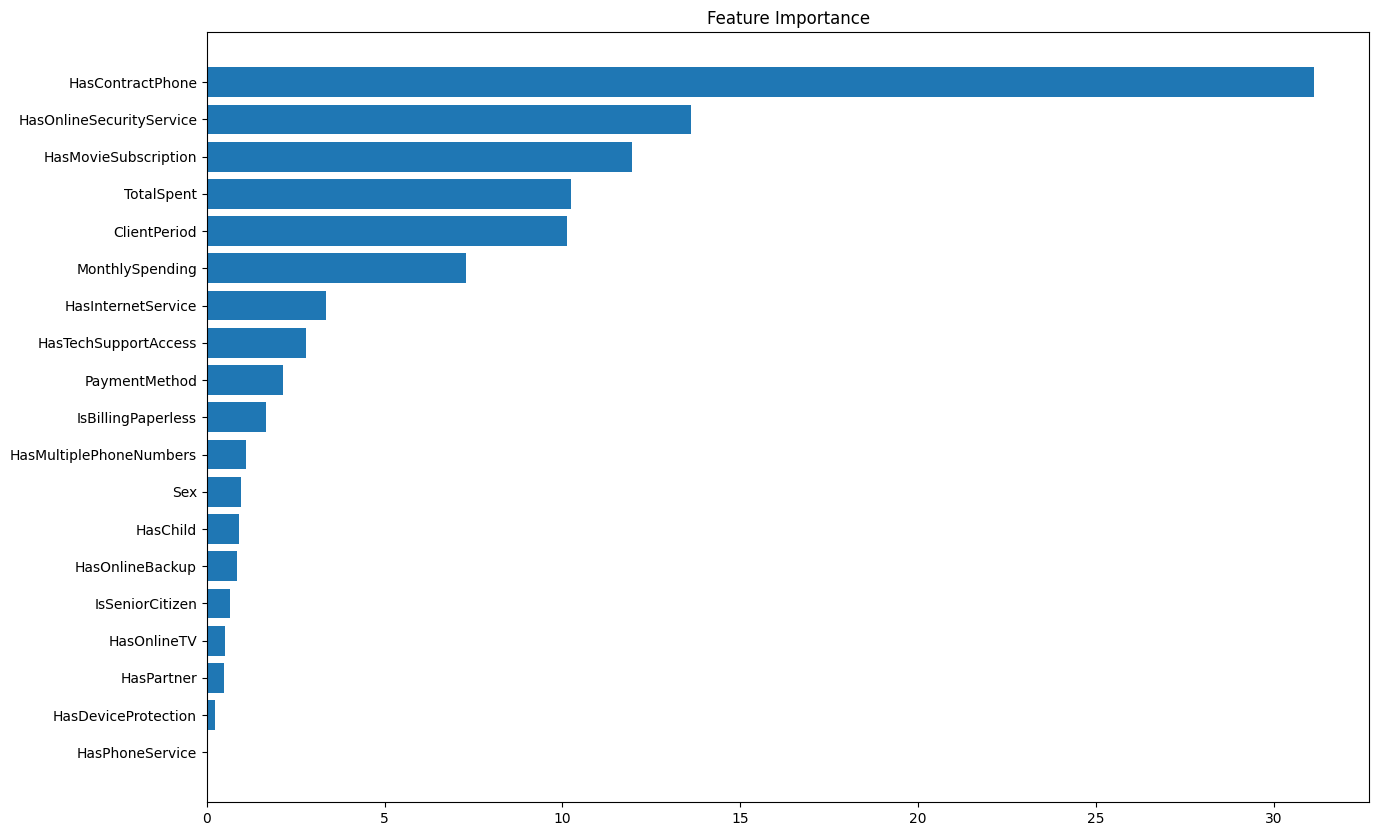

['HasContractPhone' 'HasOnlineSecurityService' 'HasMovieSubscription'
 'TotalSpent' 'ClientPeriod' 'MonthlySpending' 'HasInternetService'
 'HasTechSupportAccess' 'PaymentMethod' 'IsBillingPaperless'
 'HasMultiplePhoneNumbers' 'Sex' 'HasChild' 'HasOnlineBackup'
 'IsSeniorCitizen' 'HasOnlineTV' 'HasPartner' 'HasDeviceProtection'
 'HasPhoneService']


In [11]:
boosting.show_feats_imp()

  0%|          | 0/19 [00:00<?, ?it/s]

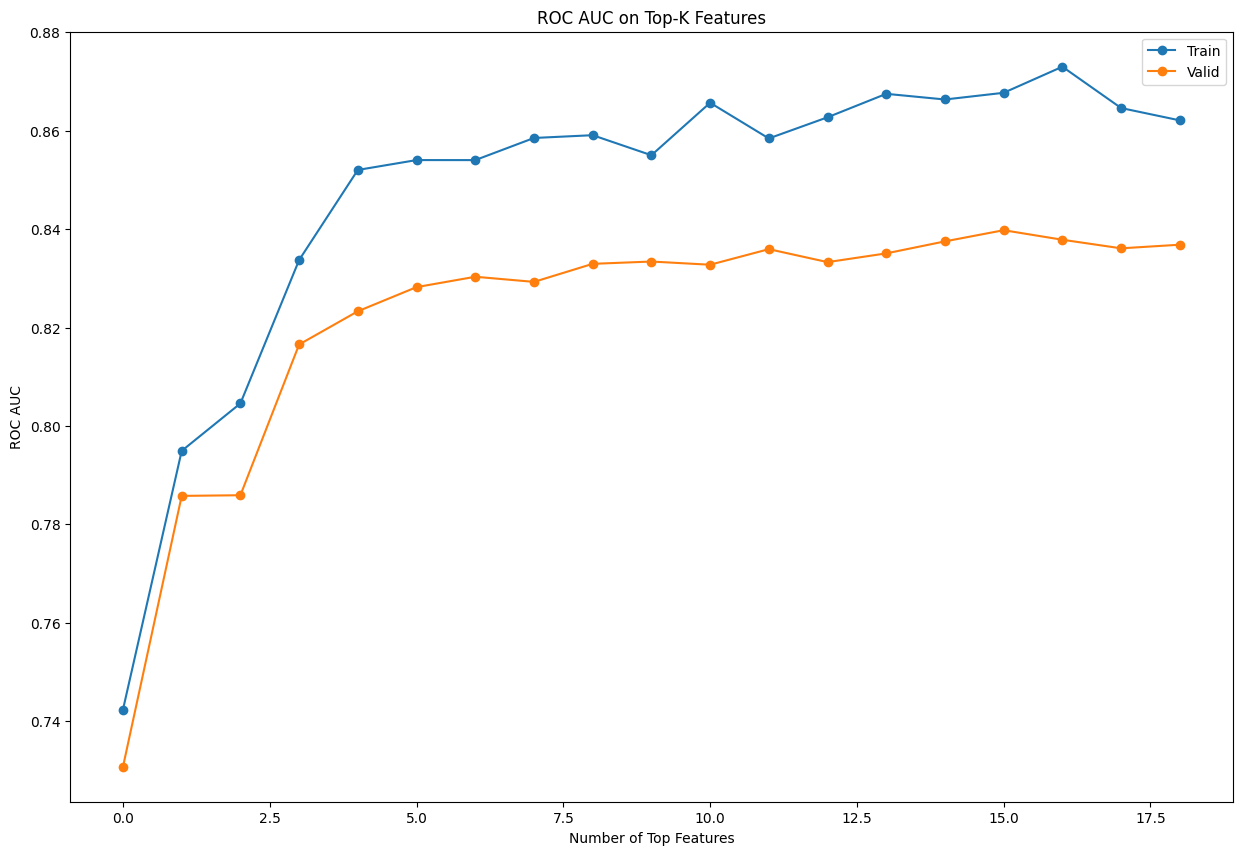

In [12]:
boosting.top_feats_selection()

In [13]:
#boosting.save_model("base_boosting.pkl")

### Optuna

In [14]:
opt_boosting = Boosting(X_train, X_val, y_train, y_val, cat_features = cat_features)

Init...
Init Finished!


In [15]:
opt_boosting.optimize_hyperparams()

[I 2023-07-17 13:40:37,148] A new study created in memory with name: no-name-01f3d37f-c1b3-4995-b79e-18fd633955e8
[I 2023-07-17 13:40:40,767] Trial 0 finished with value: 0.839074921705613 and parameters: {'objective': 'Logloss', 'learning_rate': 0.1725515465344467, 'l2_leaf_reg': 0.030274457339006473, 'colsample_bylevel': 0.09853277033616659, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 12, 'one_hot_max_size': 39, 'iterations': 2083, 'subsample': 0.36757279445224333}. Best is trial 0 with value: 0.839074921705613.
[I 2023-07-17 13:40:41,562] Trial 1 finished with value: 0.8368687316943285 and parameters: {'objective': 'Logloss', 'learning_rate': 0.21362667678389075, 'l2_leaf_reg': 0.026508502960399898, 'colsample_bylevel': 0.09094982321631077, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 43, 'one_hot_max_size': 27, 'iterations': 531}. Best is trial 0 with value: 0.839074921705613.
[I 2023-07-17 13:40:46,

Best params: {'objective': 'Logloss', 'learning_rate': 0.18137902020515265, 'l2_leaf_reg': 1.3965283508214408, 'colsample_bylevel': 0.021614598489802822, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 32, 'one_hot_max_size': 21, 'iterations': 3065, 'bagging_temperature': 2.880602722355343}


In [16]:
best_params = {
    'random_seed' : 42,
    'loss_function' : 'Logloss',
    'task_type' : 'CPU',
    'use_best_model' : True,
    'verbose' : 100,
    'thread_count' : -1,
    'early_stopping_rounds' : 100,
    'eval_metric' : 'AUC',
    'objective': 'Logloss',
    'learning_rate': 0.048808472780006044,
    'l2_leaf_reg': 0.01584024898532539,
    'colsample_bylevel': 0.09532492004748662,
    'depth': 4,
    'boosting_type': 'Plain',
    'bootstrap_type': 'Bayesian',
    'min_data_in_leaf': 39,
    'one_hot_max_size': 48,
    'iterations': 2308,
    'bagging_temperature': 1.904154569717481
}

In [17]:
best_boosting = Boosting(X_train, X_val, y_train, y_val, cat_features = cat_features, params = best_params)

Init...
Init Finished!


In [18]:
best_boosting.train()

0:	test: 0.7923170	best: 0.7923170 (0)	total: 1.41ms	remaining: 1.41s
100:	test: 0.8354307	best: 0.8354603 (99)	total: 116ms	remaining: 1.03s
200:	test: 0.8375249	best: 0.8375735 (196)	total: 232ms	remaining: 922ms
300:	test: 0.8382159	best: 0.8382708 (296)	total: 346ms	remaining: 804ms
400:	test: 0.8387453	best: 0.8387453 (400)	total: 466ms	remaining: 695ms
500:	test: 0.8383913	best: 0.8389608 (467)	total: 581ms	remaining: 578ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8389608084
bestIteration = 467

Shrink model to first 468 iterations.
ROC AUC на обучающей выборке: 0.8829125675695911
ROC AUC на валидационной выборке: 0.8389608084291673


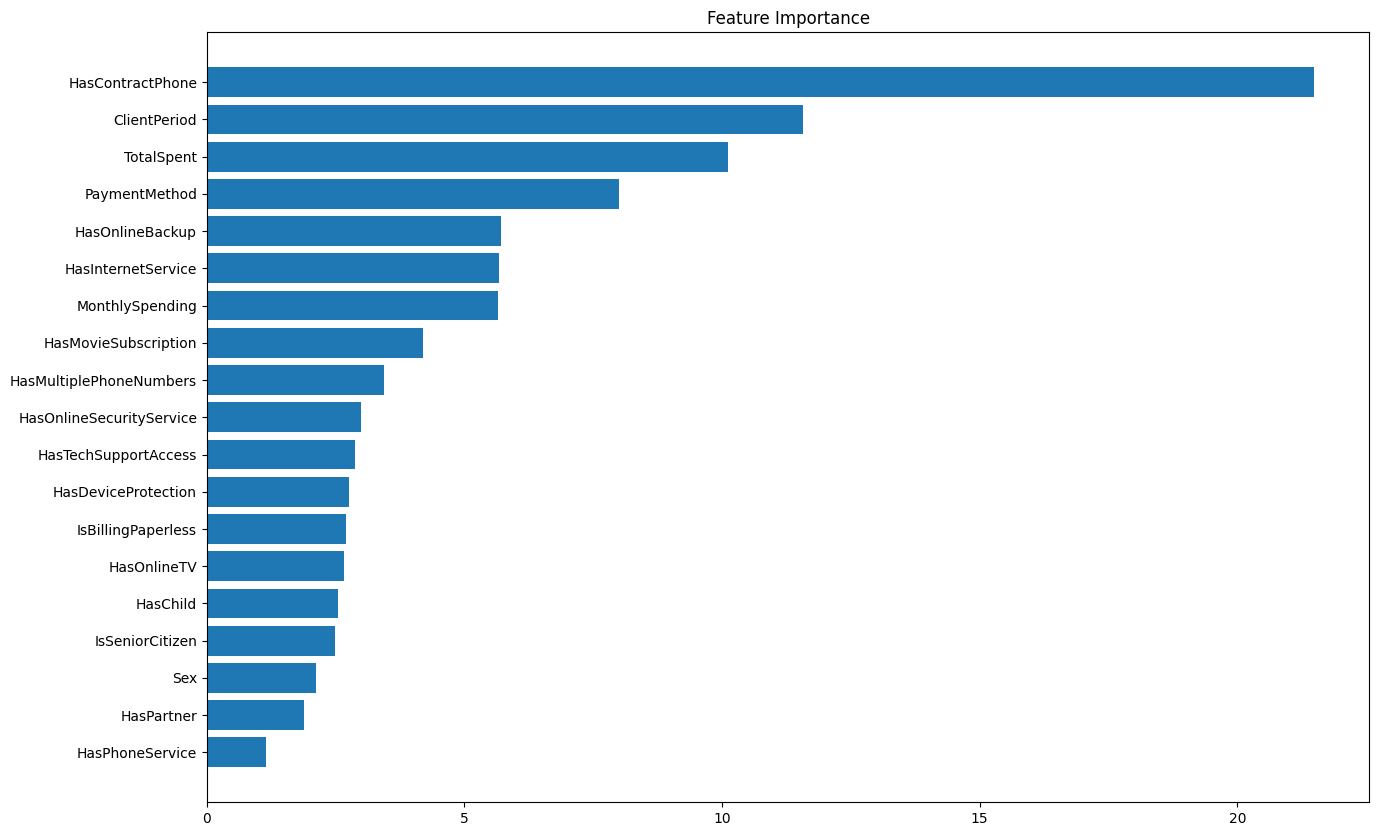

['HasContractPhone' 'ClientPeriod' 'TotalSpent' 'PaymentMethod'
 'HasOnlineBackup' 'HasInternetService' 'MonthlySpending'
 'HasMovieSubscription' 'HasMultiplePhoneNumbers'
 'HasOnlineSecurityService' 'HasTechSupportAccess' 'HasDeviceProtection'
 'IsBillingPaperless' 'HasOnlineTV' 'HasChild' 'IsSeniorCitizen' 'Sex'
 'HasPartner' 'HasPhoneService']


In [19]:
best_boosting.show_feats_imp()

  0%|          | 0/19 [00:00<?, ?it/s]

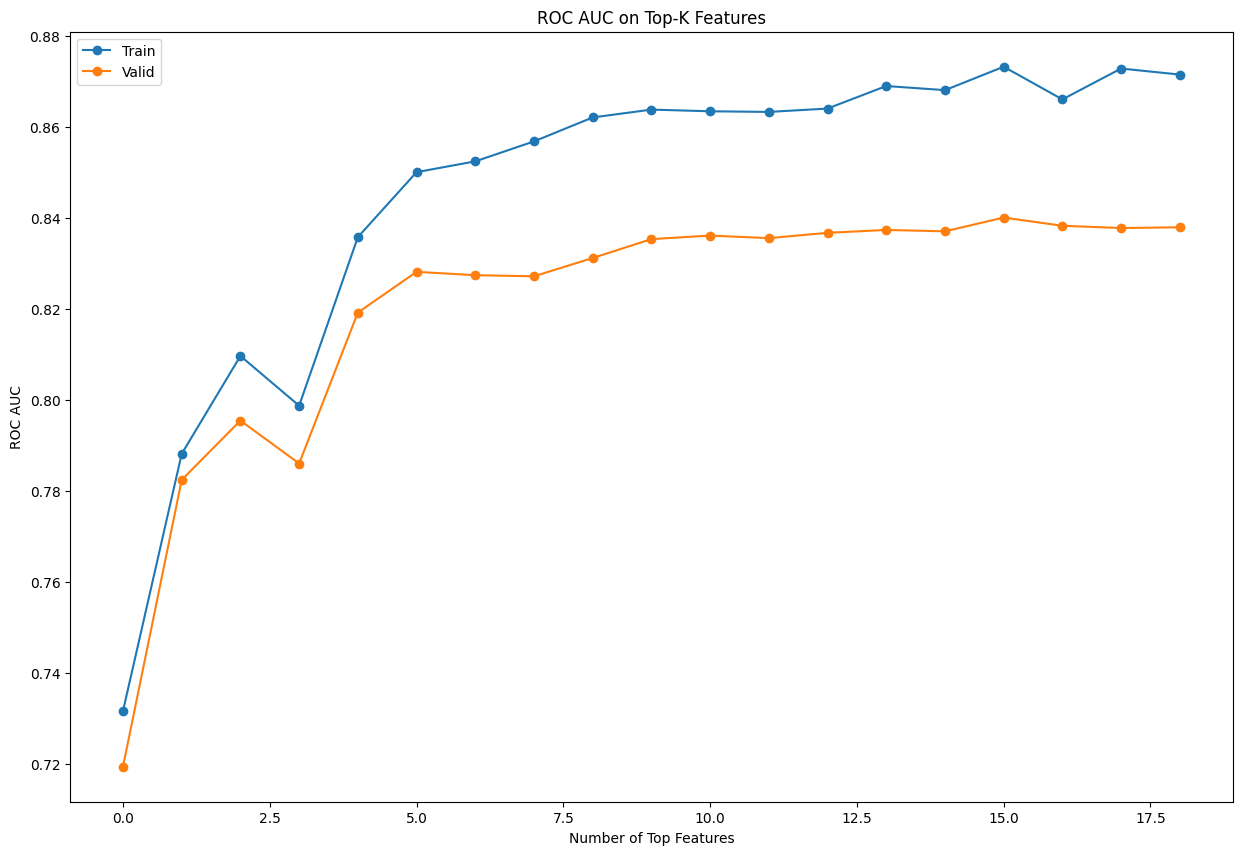

In [20]:
best_boosting.top_feats_selection()